In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing insta

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
import random
from scipy.stats import mode


In [2]:
def load_gse_file(filepath):
    """
    Load and clean GSE stock data from manually downloaded CSV files.
    Works for ETI, GOIL and all GSE equities exported from gse.com.gh.
    """

    # Load raw CSV
    df = pd.read_csv(filepath)
    print("Raw shape:", df.shape)
    print("Raw columns:", df.columns.tolist())

    # Standardize column names for consistency
    df = df.rename(columns={
        "Daily Date": "date",
        "Share Code": "ticker",
        "Year High (GH¢)": "high",
        "Year Low (GH¢)": "low",
        "Previous Closing Price - VWAP (GH¢)": "prev_close",
        "Opening Price (GH¢)": "open",
        "Last Transaction Price (GH¢)": "last_price",
        "Closing Price - VWAP (GH¢)": "close",
        "Price Change (GH¢)": "change",
        "Closing Bid Price (GH¢)": "bid",
        "Closing Offer Price (GH¢)": "ask",
        "Total Shares Traded": "volume",
        "Total Value Traded (GH¢)": "value"
    })

    # Keep only the relevant fields
    df = df[["date", "open", "high", "low", "close", "volume"]]

    # Convert date format
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

    # Remove invalid rows
    df = df.dropna(subset=["date"])

    # Sort by date (very important)
    df = df.sort_values("date").reset_index(drop=True)

    print("Cleaned shape:", df.shape)
    print(df.head())

    return df


In [3]:
goil_df = load_gse_file("/content/GOIL_gse.csv")


Raw shape: (2892, 13)
Raw columns: ['Daily Date', 'Share Code', 'Year High (GH¢)', 'Year Low (GH¢)', 'Previous Closing Price - VWAP (GH¢)', 'Opening Price (GH¢)', 'Last Transaction Price (GH¢)', 'Closing Price - VWAP (GH¢)', 'Price Change (GH¢)', 'Closing Bid Price (GH¢)', 'Closing Offer Price (GH¢)', 'Total Shares Traded', 'Total Value Traded (GH¢)']
Cleaned shape: (2892, 6)
        date  open  high   low  close        volume
0 2007-11-16  0.22  0.22  0.22   0.22     62,800.00
1 2007-11-19  0.22  0.22  0.22   0.22          0.00
2 2007-11-20  0.22  0.22  0.22   0.22          0.00
3 2007-11-21  0.22  0.23  0.22   0.23  1,090,400.00
4 2007-11-22  0.23  0.23  0.22   0.23          0.00


In [4]:
data = goil_df.copy()

In [5]:
data["volume"] = (
    data["volume"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("GH¢", "", regex=False)
    .str.replace("GHC", "", regex=False)
    .str.replace("'", "", regex=False)
    .str.strip()
)

data["volume"] = pd.to_numeric(data["volume"], errors="coerce")


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2892 entries, 0 to 2891
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2892 non-null   datetime64[ns]
 1   open    2892 non-null   float64       
 2   high    2892 non-null   float64       
 3   low     2892 non-null   float64       
 4   close   2892 non-null   float64       
 5   volume  2889 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 135.7 KB


In [7]:
display(data.select_dtypes(include=[np.number]).describe())


,open,high,low,close,volume
count,2892.000000,2892.000000,2892.000000,2892.000000,2.889000e+03
mean,1.139547,1.336055,0.916193,1.140636,5.053415e+04
std,1.050514,1.305168,0.875204,1.051253,6.354718e+05
min,0.140000,0.170000,0.020000,0.140000,0.000000e+00
25%,0.310000,0.330000,0.280000,0.310000,3.000000e+02
50%,0.900000,1.000000,0.620000,0.900000,3.300000e+03
75%,1.410000,1.520000,1.090000,1.410000,1.620000e+04
max,5.010000,5.050000,4.350000,5.010000,2.234838e+07


In [8]:
# Indicators
data["sma"] = ta.sma(data["close"], 14)
data["ema"] = ta.ema(data["close"], 14)
data["macd"] = ta.macd(data["close"])["MACD_12_26_9"]
data["rsi"] = ta.rsi(data["close"], 14)
data["obv"] = ta.obv(data["close"], data["volume"])
st = ta.stoch(data["high"], data["low"], data["close"])
data["stoch_k"] = st["STOCHk_14_3_3"]
data["stoch_d"] = st["STOCHd_14_3_3"]

# AR, VR
data["ar"] = (data["high"] - data["open"]) / (data["open"] - data["low"] + 1e-9)
data["vr"] = data["volume"] / data["volume"].rolling(14).mean()

# Target (10-day ahead movement)
data["future_close"] = data["close"].shift(-10)
data["target"] = np.where(data["future_close"] > data["close"], 1, -1)

data = data.dropna()


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 25 to 2881
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2820 non-null   datetime64[ns]
 1   open          2820 non-null   float64       
 2   high          2820 non-null   float64       
 3   low           2820 non-null   float64       
 4   close         2820 non-null   float64       
 5   volume        2820 non-null   float64       
 6   sma           2820 non-null   float64       
 7   ema           2820 non-null   float64       
 8   macd          2820 non-null   float64       
 9   rsi           2820 non-null   float64       
 10  obv           2820 non-null   float64       
 11  stoch_k       2820 non-null   float64       
 12  stoch_d       2820 non-null   float64       
 13  ar            2820 non-null   float64       
 14  vr            2820 non-null   float64       
 15  future_close  2820 non-null   float64     

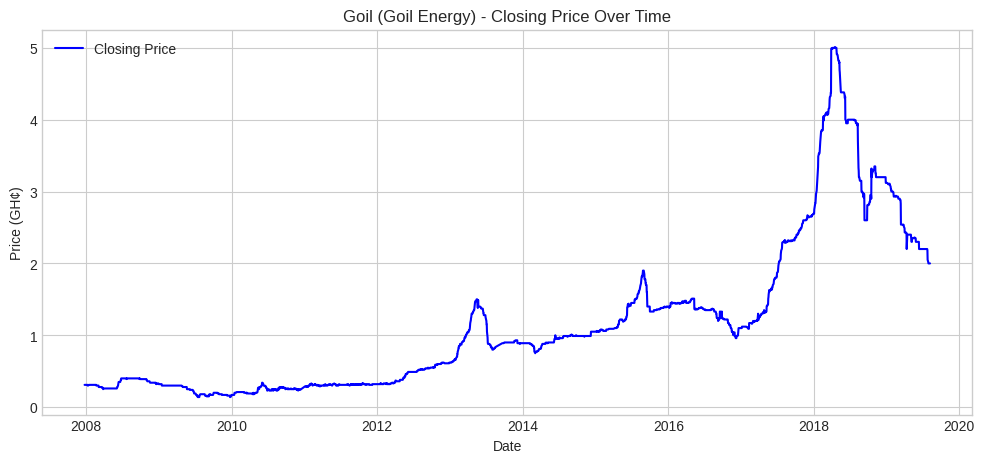

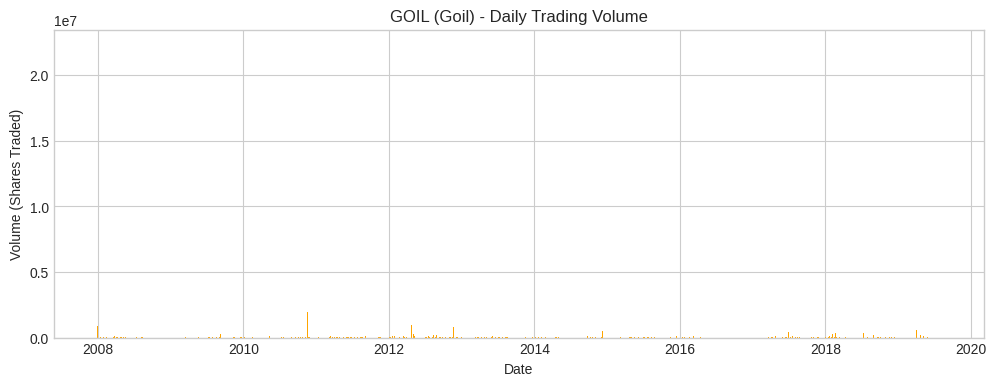

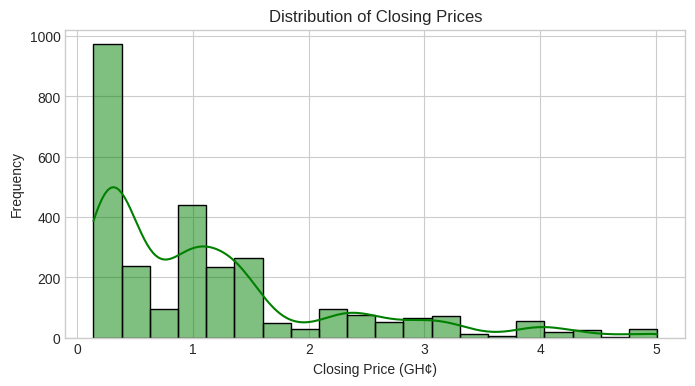

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# =======================================================
# 1️⃣ Time Series Plot of Closing Price
# =======================================================
plt.figure(figsize=(12, 5))
plt.plot(data["date"], data["close"], label="Closing Price", color="blue")
plt.title("Goil (Goil Energy) - Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (GH¢)")
plt.legend()
plt.show()

# =======================================================
# 2️⃣ Trading Volume Over Time
# =======================================================
plt.figure(figsize=(12, 4))
plt.bar(data["date"], data["volume"], color="orange")
plt.title("GOIL (Goil) - Daily Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume (Shares Traded)")
plt.show()

# =======================================================
# 3️⃣ Distribution of Prices
# =======================================================
plt.figure(figsize=(8, 4))
sns.histplot(data["close"], bins=20, kde=True, color="green")
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price (GH¢)")
plt.ylabel("Frequency")
plt.show()




In [11]:
features = [
    "open", "high", "low", "close", "volume",
    "sma", "ema", "macd", "rsi", "obv",
    "stoch_k", "stoch_d", "ar", "vr"
]

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Show Final Data

print("Final shape:", data.shape)
display(data.head(10))

Final shape: (2820, 17)


,date,open,high,low,close,volume,sma,ema,macd,rsi,obv,stoch_k,stoch_d,ar,vr,future_close,target
25,2007-12-24,0.034908,0.028689,0.046189,0.034908,0.002868,0.026529,0.026745,0.517221,1.00000,0.277126,0.537143,0.534934,0.004673,0.065976,0.30,-1
26,2007-12-27,0.034908,0.028689,0.046189,0.034908,0.000103,0.027266,0.027472,0.516752,1.00000,0.277126,0.537143,0.534934,0.004673,0.002392,0.30,-1
27,2007-12-28,0.034908,0.028689,0.046189,0.034908,0.000000,0.028003,0.028102,0.515800,1.00000,0.277126,0.537143,0.534934,0.004673,0.000000,0.31,-1
28,2007-12-31,0.034908,0.028689,0.046189,0.034908,0.038942,0.028740,0.028649,0.514482,1.00000,0.277126,0.537143,0.534934,0.004673,0.498888,0.31,-1
29,2008-01-02,0.034908,0.028689,0.046189,0.034908,0.034768,0.029329,0.029122,0.512891,1.00000,0.277126,0.537143,0.534934,0.004673,0.311381,0.31,-1
30,2008-01-03,0.034908,0.028689,0.066975,0.034908,0.000000,0.029919,0.029533,0.511105,1.00000,0.277126,0.537143,0.534934,0.004673,0.000000,0.31,-1
31,2008-01-04,0.034908,0.028689,0.066975,0.034908,0.014350,0.030508,0.029888,0.509186,1.00000,0.277126,0.537143,0.534934,0.004673,0.114018,0.31,-1
32,2008-01-07,0.034908,0.028689,0.066975,0.034908,0.000161,0.031098,0.030197,0.507185,1.00000,0.277126,0.537143,0.534934,0.004673,0.001278,0.31,-1
33,2008-01-08,0.034908,0.028689,0.066975,0.034908,0.002036,0.031688,0.030464,0.505143,1.00000,0.277126,0.537143,0.534934,0.004673,0.016137,0.31,-1
34,2008-01-09,0.034908,0.028689,0.064665,0.032854,0.001351,0.031982,0.030416,0.501571,0.70234,0.275722,0.520000,0.529193,0.004673,0.011331,0.31,1


In [12]:
from sklearn.model_selection import train_test_split

# Features and target
X = data[[
    "open", "high", "low", "close", "volume",
    "sma", "ema", "macd", "rsi", "obv",
    "stoch_k", "stoch_d", "ar", "vr"
]]
y = data["target"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2256, 14)
Test shape: (564, 14)


In [13]:
data['target'].value_counts(normalize=True)


,proportion
target,
-1,0.579078
1,0.420922


In [14]:
# GA Hyperparameters

POP_SIZE = 250       # number of chromosomes in population
N_GENERATIONS = 50  # number of generations to evolve
MUTATION_RATE = 0.1 # probability of mutation
CROSSOVER_RATE = 0.85
TOP_K = 15          # top chromosomes to keep for ensemble

N_FEATURES = X_train.shape[1]

# For reproducibility
random.seed(42)
np.random.seed(42)


In [15]:
def create_chromosome():
    feature_mask = np.random.randint(0, 2, size=N_FEATURES)
    C = np.random.uniform(0.1, 100)       # SVM C parameter range
    gamma = np.random.uniform(0.0001, 1)  # SVM gamma range
    return np.concatenate([feature_mask, [C, gamma]])


In [16]:
def fitness(chromosome):
    # Decode chromosome
    feature_mask = chromosome[:N_FEATURES].astype(bool)
    C = chromosome[-2]
    gamma = chromosome[-1]

    # Prevent empty feature subset
    if feature_mask.sum() == 0:
        return 0

    # Select features
    X_tr = X_train.loc[:, feature_mask]
    X_te = X_test.loc[:, feature_mask]

    # Train SVM
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    # Return accuracy as fitness
    return accuracy_score(y_test, y_pred)


In [18]:
def selection(population, fitness_scores):
    # Tournament selection (pick 2, choose better)
    i, j = np.random.randint(0, len(population), 2)
    return population[i] if fitness_scores[i] > fitness_scores[j] else population[j]

def crossover(parent1, parent2):
    if np.random.rand() > CROSSOVER_RATE:
        return parent1.copy(), parent2.copy()

    # Single-point crossover on feature mask
    point = np.random.randint(1, N_FEATURES)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

def mutate(chromosome):
    for i in range(N_FEATURES):
        if np.random.rand() < MUTATION_RATE:
            chromosome[i] = 1 - chromosome[i]  # flip bit
    # Small random changes in C and gamma
    chromosome[-2] *= np.random.uniform(0.9, 1.1)
    chromosome[-1] *= np.random.uniform(0.9, 1.1)
    return chromosome


In [19]:
# Initialize population
population = [create_chromosome() for _ in range(POP_SIZE)]

for gen in range(N_GENERATIONS):
    fitness_scores = [fitness(ch) for ch in population]
    best_idx = np.argmax(fitness_scores)
    print(f"Generation {gen+1}/{N_GENERATIONS} - Best Fitness: {fitness_scores[best_idx]:.4f}")

    new_population = []
    while len(new_population) < POP_SIZE:
        # Selection
        p1 = selection(population, fitness_scores)
        p2 = selection(population, fitness_scores)
        # Crossover + Mutation
        c1, c2 = crossover(p1, p2)
        new_population.append(mutate(c1))
        if len(new_population) < POP_SIZE:
            new_population.append(mutate(c2))
    population = new_population

# Evaluate final population
final_scores = [fitness(ch) for ch in population]
sorted_idx = np.argsort(final_scores)[::-1]
best_chromosomes = [population[i] for i in sorted_idx[:TOP_K]]

print("\nTop Chromosomes Selected for Ensemble:")
for i, score in enumerate(np.array(final_scores)[sorted_idx[:TOP_K]]):
    print(f"#{i+1}: Fitness={score:.4f}")


Generation 1/50 - Best Fitness: 0.8883
Generation 2/50 - Best Fitness: 0.9007
Generation 3/50 - Best Fitness: 0.9025
Generation 4/50 - Best Fitness: 0.9025
Generation 5/50 - Best Fitness: 0.9007
Generation 6/50 - Best Fitness: 0.9007
Generation 7/50 - Best Fitness: 0.9025
Generation 8/50 - Best Fitness: 0.9025
Generation 9/50 - Best Fitness: 0.9025
Generation 10/50 - Best Fitness: 0.9007
Generation 11/50 - Best Fitness: 0.9007
Generation 12/50 - Best Fitness: 0.9007
Generation 13/50 - Best Fitness: 0.9007
Generation 14/50 - Best Fitness: 0.9007
Generation 15/50 - Best Fitness: 0.9025
Generation 16/50 - Best Fitness: 0.9007
Generation 17/50 - Best Fitness: 0.9007
Generation 18/50 - Best Fitness: 0.9007
Generation 19/50 - Best Fitness: 0.9025
Generation 20/50 - Best Fitness: 0.8989
Generation 21/50 - Best Fitness: 0.9007
Generation 22/50 - Best Fitness: 0.9025
Generation 23/50 - Best Fitness: 0.9007
Generation 24/50 - Best Fitness: 0.9025
Generation 25/50 - Best Fitness: 0.9025
Generatio

In [20]:
# Train top 15 SVMs and get predictions
ensemble_preds = []

for i, chrom in enumerate(best_chromosomes, 1):
    feature_mask = chrom[:N_FEATURES].astype(bool)
    C = chrom[-2]
    gamma = chrom[-1]

    # Select features
    X_tr = X_train.loc[:, feature_mask]
    X_te = X_test.loc[:, feature_mask]

    # Train individual SVM
    model = SVC(C=C, gamma=gamma, kernel='rbf', probability=True)
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    ensemble_preds.append(y_pred)

    print(f"Model #{i} trained with C={C:.4f}, gamma={gamma:.4f}, features={feature_mask.sum()}")

# Combine Predictions (Majority Voting)

ensemble_preds = np.array(ensemble_preds)
final_pred, _ = mode(ensemble_preds, axis=0)
final_pred = final_pred.flatten()


Model #1 trained with C=22.6631, gamma=0.1111, features=9
Model #2 trained with C=21.0720, gamma=0.1565, features=6
Model #3 trained with C=11.5823, gamma=0.1712, features=8
Model #4 trained with C=7.1266, gamma=0.1749, features=8
Model #5 trained with C=15.8017, gamma=0.1381, features=6
Model #6 trained with C=15.8791, gamma=0.1022, features=10
Model #7 trained with C=5.8852, gamma=0.2225, features=10
Model #8 trained with C=16.9688, gamma=0.1764, features=7
Model #9 trained with C=43.8730, gamma=0.0908, features=8
Model #10 trained with C=6.4537, gamma=0.2267, features=7
Model #11 trained with C=18.0435, gamma=0.0860, features=10
Model #12 trained with C=6.1631, gamma=0.2686, features=6
Model #13 trained with C=8.3276, gamma=0.1730, features=9
Model #14 trained with C=14.8132, gamma=0.0888, features=8
Model #15 trained with C=12.1769, gamma=0.1575, features=9


In [21]:

# Evaluation Metrics

acc = accuracy_score(y_test, final_pred)
cm = confusion_matrix(y_test, final_pred)
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
mae = mean_absolute_error(y_test, final_pred)

# AUC (requires probabilistic output)
ensemble_probs = []
for i, chrom in enumerate(best_chromosomes):
    feature_mask = chrom[:N_FEATURES].astype(bool)
    C = chrom[-2]
    gamma = chrom[-1]
    model = SVC(C=C, gamma=gamma, kernel='rbf', probability=True)
    model.fit(X_train.loc[:, feature_mask], y_train)
    ensemble_probs.append(model.predict_proba(X_test.loc[:, feature_mask])[:, 1])
ensemble_probs = np.mean(ensemble_probs, axis=0)
auc = roc_auc_score((y_test == 1).astype(int), ensemble_probs)

# Results

print("\n=== GASVM Ensemble Performance ===")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print("\nConfusion Matrix:")
print(cm)



=== GASVM Ensemble Performance ===
Accuracy: 0.8989
AUC: 0.9057
RMSE: 0.6358
MAE: 0.2021

Confusion Matrix:
[[293  17]
 [ 40 214]]


,proportion
target,
-1,0.579078
1,0.420922
